In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [8]:
#variables to modify
n_sensors = 22
time_header = "Timestamp" #header of the timestamp column
folder_name = 'level1_bluesky_data'
first_timestamp = "2023-12-18 00:00:00"
last_timestamp = "2023-12-31 16:00:00" #--fill data if there are missing values between these timestamps
parameters = ["PM 1.0", "PM 2.5", "PM 4.0", "PM 10"] #set the parameter you want to harmonize; 
#the parameter name should be exactly the same as in the headers in the csv files, written in a list, ex. ["PM 2.5", "PM 1.0", "CO2"]

In [10]:
#read data
data = []
data = [pd.read_csv(f'{folder_name}/B' + str(i+1) + '_15minute_average.csv') for i in range(n_sensors)]

print("checking the lengths of the sensor data:")
u = [len(data[i].index) for i in range(n_sensors)]
print(u)

#---------------------------------------
#convert the timestamps to datetime type
for i in range(n_sensors):
    data[i][time_header] = pd.to_datetime(data[i][time_header])

#set the timestamps as index
start = pd.to_datetime(first_timestamp)
end = pd.to_datetime(last_timestamp)
dates = pd.date_range(start=start, end=end, freq='15Min')

#fill the missing values with nan
data = [data[i].set_index(time_header).reindex(dates).reset_index() for i in range(n_sensors)]

#create a folder to save results of harmonization
result_folder = 'harmonization_results'
level2_folder = 'level2_data'
if not os.path.isdir(result_folder):
    os.makedirs(f'./{result_folder}/{level2_folder}')


checking the lengths of the sensor data:
[1313, 1313, 1313, 1038, 1313, 1313, 1313, 1313, 1299, 1313, 1070, 1313, 1313, 1313, 1313, 1313, 1313, 1313, 1313, 1284, 1313, 1070]


In [11]:
def harmonize(parameter):

    #finding the median values for each timestamp - 'parameter_data' is 2-dimensional arrays to store the values of the parameter for all sensors
    parameter_data = [data[i][parameter].values for i in range(n_sensors)]

    #cut off sensors with missing days to find the median in a simpler way
    parameter_data = np.array([parameter_data[i] for i in range(n_sensors) if len(parameter_data[i]) == len(parameter_data[0])])
    median = np.nanmedian(parameter_data, axis=0)

    #-------------------------------------------------
    #for plotting
    figure, axis = plt.subplots(5, n_sensors//5+1)

    #for regression
    def func(x, a, b):
        return a*x + b

    #to save calibration factors
    calibration_factors = np.zeros(n_sensors)
    #to save harmonized data
    harmonized_data = np.zeros((n_sensors, len(median)))

    x = median
    print(f'calculating harmonization data for {parameter} ...')
    for i in range(n_sensors):
        try:
            #plot the sensors' data against the median (the values are centralized to zero)
            axis[i//5, i%5].plot(data[0][parameter], data[i][parameter], 'o')
            axis[i//5, i%5].set_title(f"Sensor {i+1}")
            axis[i//5, i%5].set_xlabel("median")

            #regression for slope
            y = data[i][parameter].values
            
            #to omit values with nan
            valid = ~ (np.isnan(x) | np.isnan(y))

            #regression (the values are centralized to zero, by setting the intercept to zero)
            popt, pcov = curve_fit(func, x[valid], y[valid], bounds=([-np.inf, -0.000001], [np.inf, 0.000001]))
            calibration_factors[i] = round(1/popt[0], 3)
            #print(f"sensor {i+1}:y={popt[0].round(3)}x")

            #plot the regression line
            axis[i//5, i%5].plot(x, func(x, *popt), 'r--')
            axis[i//5, i%5].text(0.1, 0.9, f"y={popt[0].round(3)}x", transform=axis[i//5, i%5].transAxes)

            
        except ValueError as e:
            print(f"Sensor {i+1} has missing values, check individually; the error is '{e}'")

    #increase the plot's size
    figure.set_size_inches(16.5, 16.5)
    
    plt.suptitle(f"{parameter} Harmonization", fontsize=16)

    plt.savefig(f'{result_folder}/{parameter}_calibration_fitting.png', dpi=300)
    #plt.show()

    #
    #plots
    #plot the parameter vs time, truncating before 408
    plt.figure(figsize=(16,9))
    plt.plot(dates[:], median[:], label="median")
    for i in range(n_sensors):
        plt.plot(dates[:], data[i][parameter].iloc[:]*calibration_factors[i], label=f"sensor {i+1}")

    #save the harmonized data in csv files
    for i in range(n_sensors):
        harmonized_data[i][:] = data[i][parameter]*calibration_factors[i]

    #cosmetics of the plot
    plt.xlabel("Date", fontsize=16)
    plt.ylabel(parameter, fontsize=16)
    plt.legend(loc="upper right")
    plt.title(f"{parameter} Harmonization", fontsize=16)
    plt.savefig(f'{result_folder}/{parameter}_calibration.png', dpi=300)
    #plt.show()

    return calibration_factors, harmonized_data


/home/sakengali/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


calculating harmonization data for PM 1.0 ...
calculating harmonization data for PM 2.5 ...
calculating harmonization data for PM 4.0 ...
calculating harmonization data for PM 10 ...


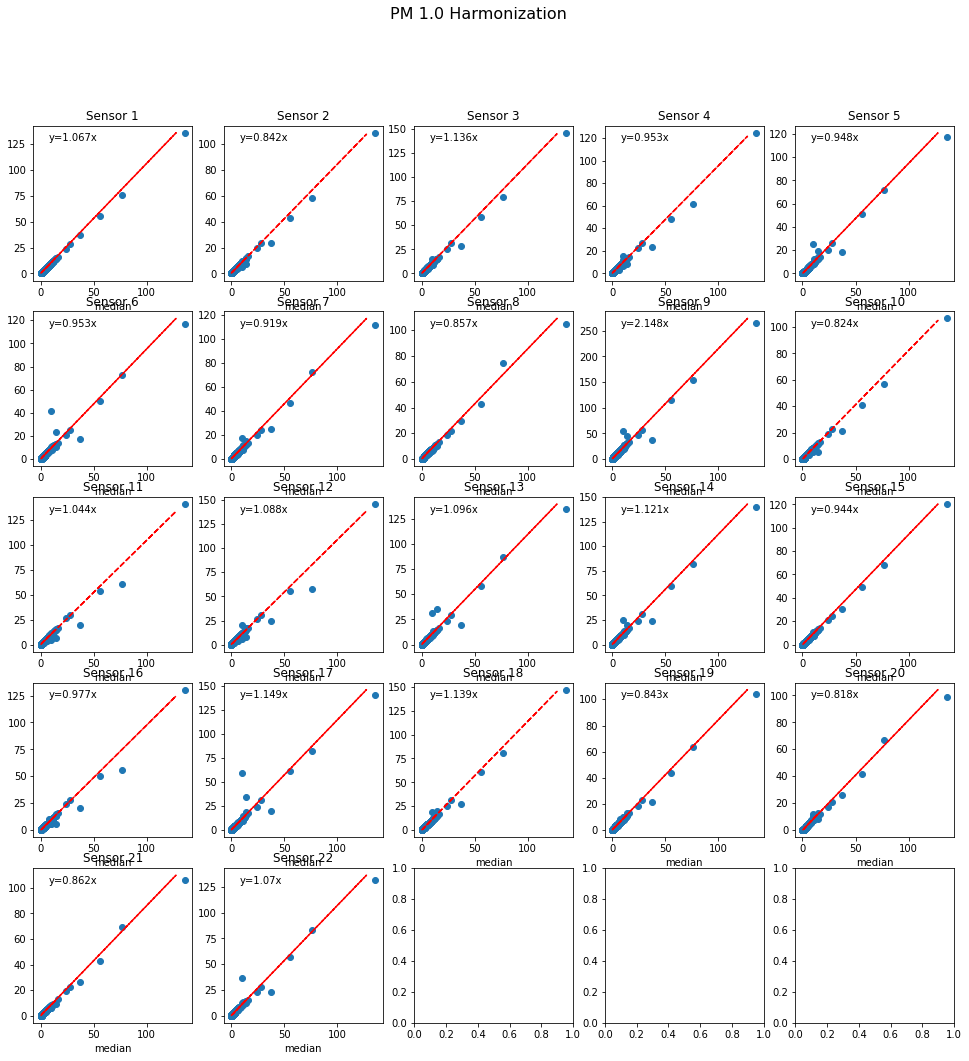

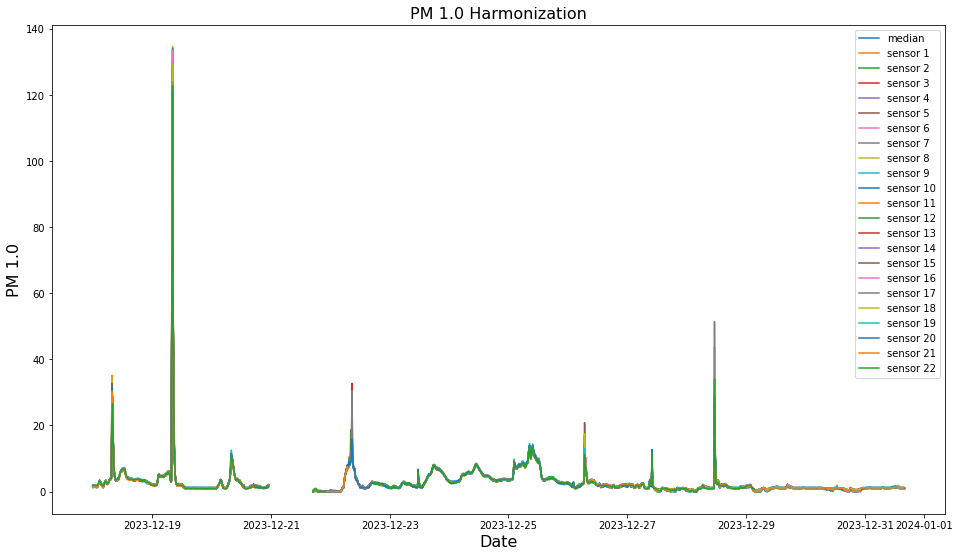

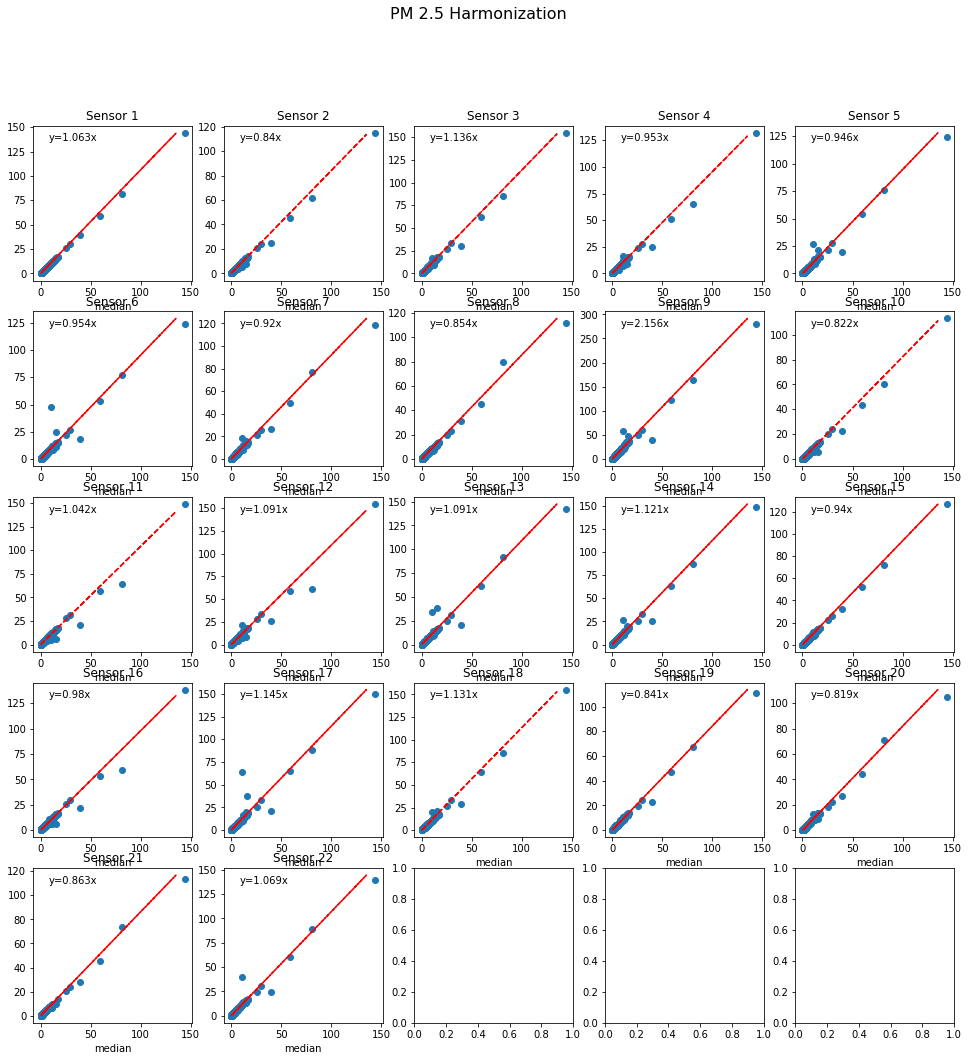

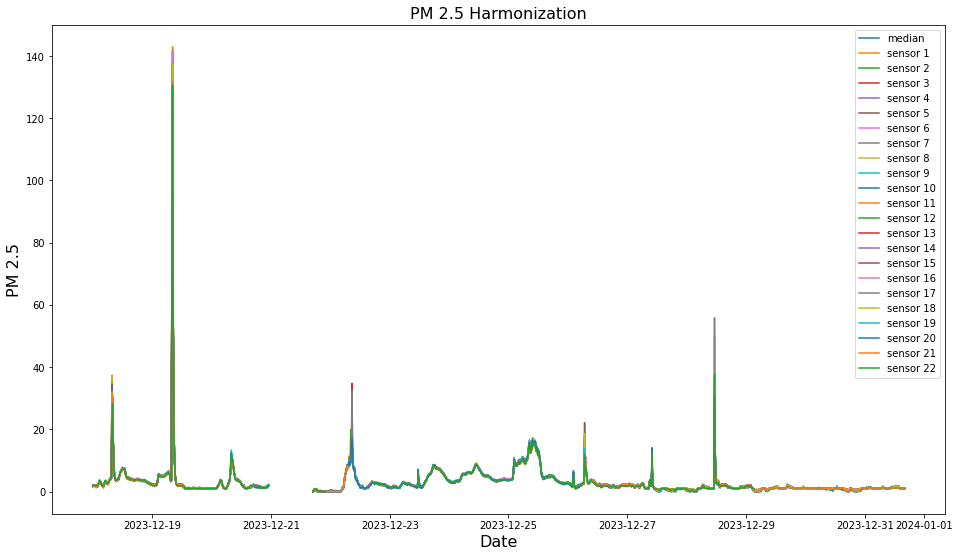

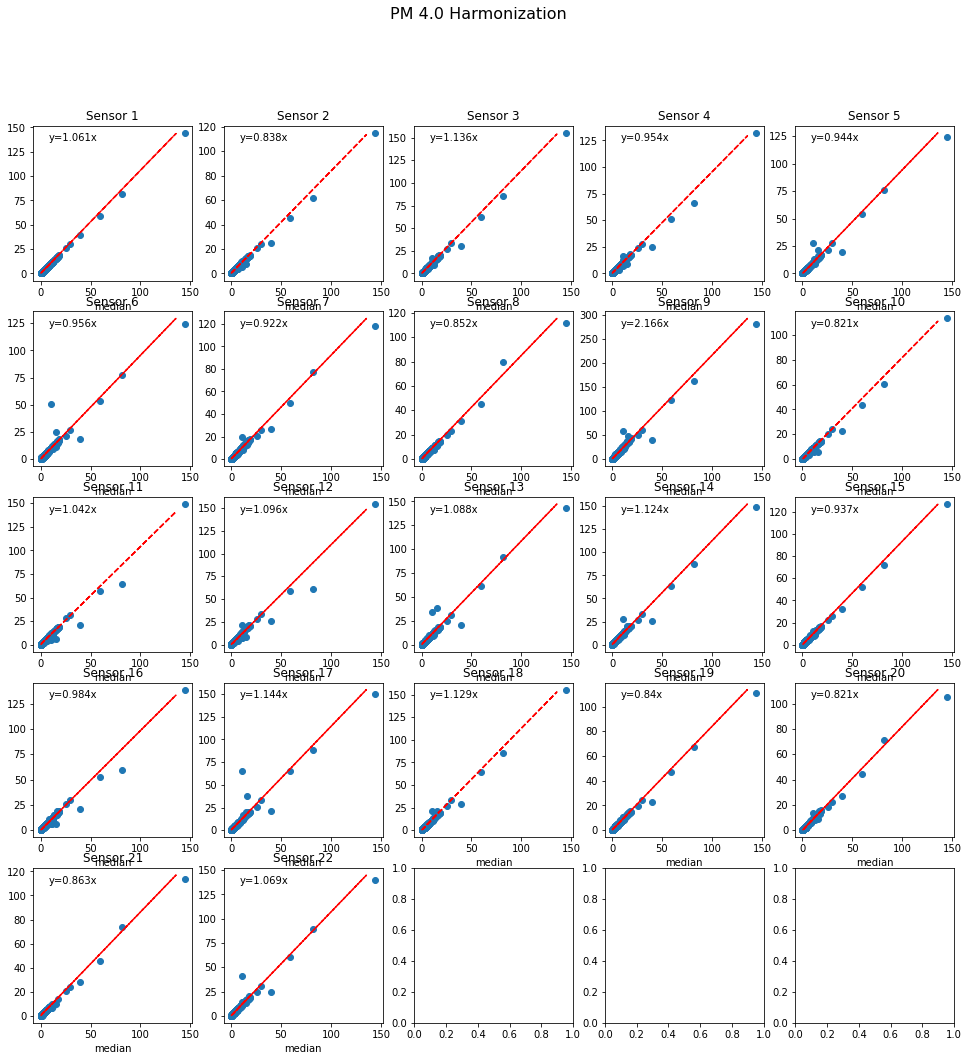

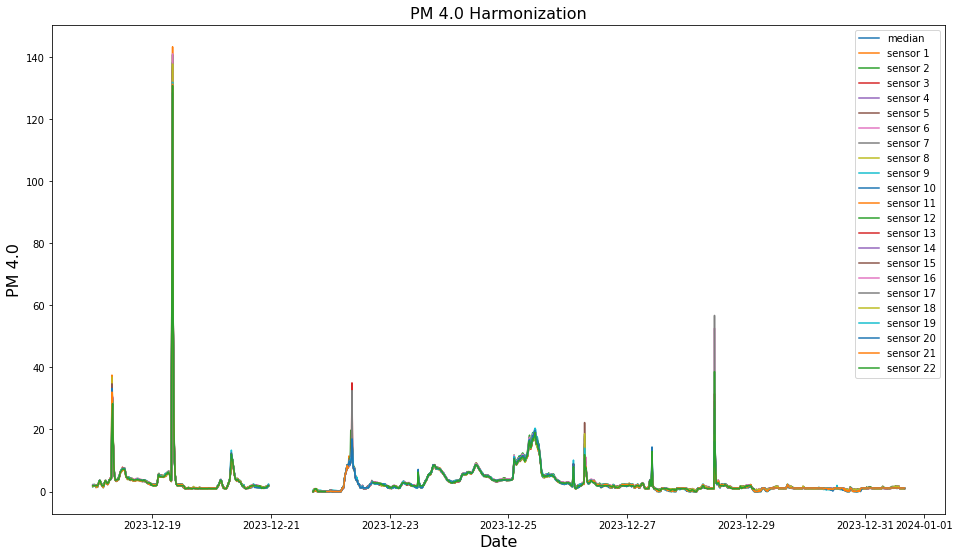

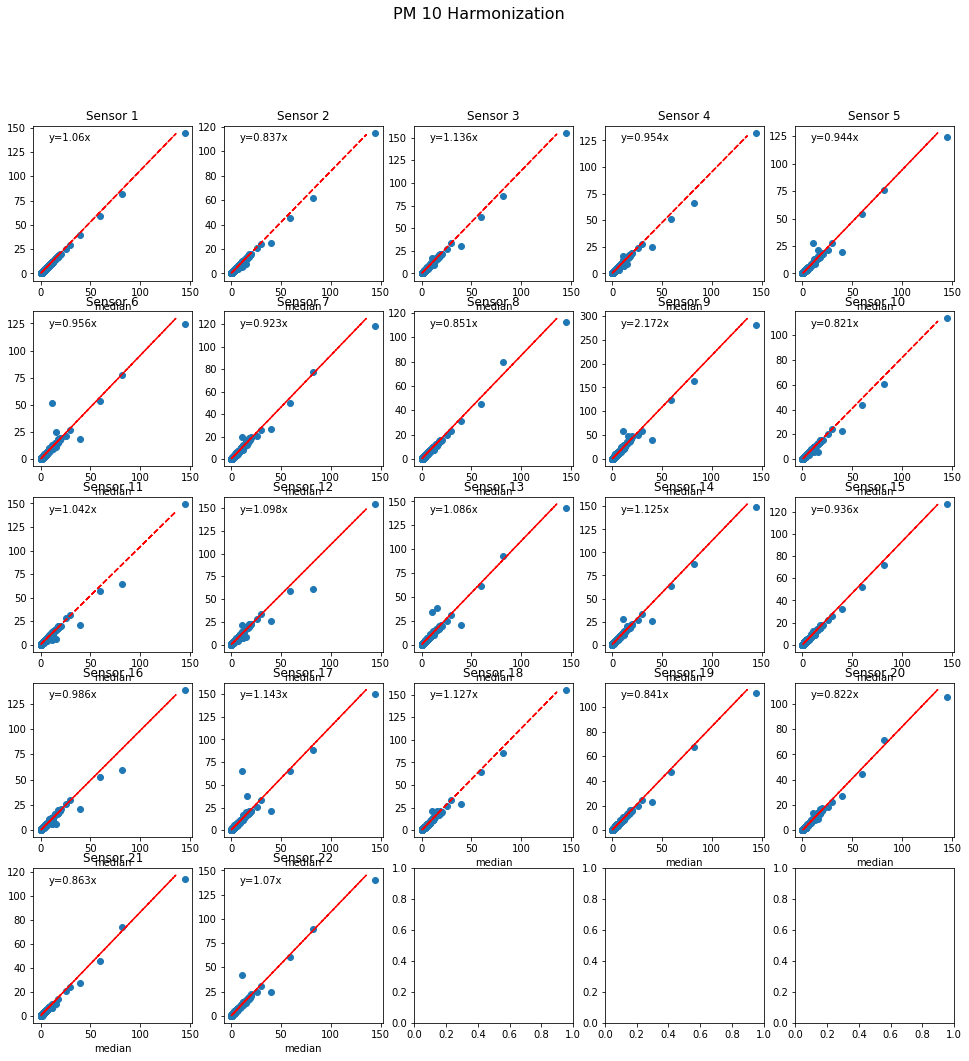

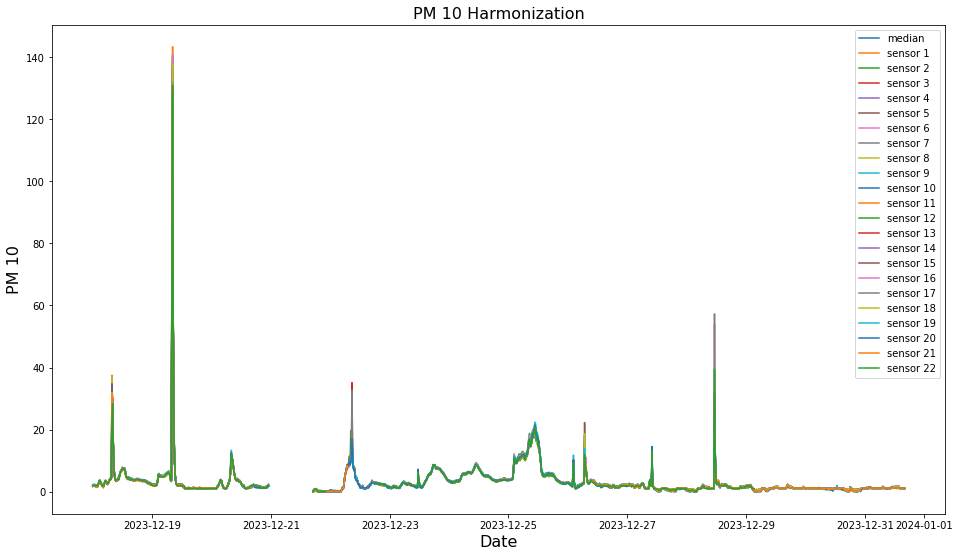

In [12]:
#get the data from harmonization
res_data = [harmonize(p) for p in parameters]

In [17]:
#get calibration factors and harmonized data
calibration_factors = [res_data[i][0] for i, _ in enumerate(parameters)]
harmonized_data = [res_data[i][1] for i, _ in enumerate(parameters)]

#save the harmonized data in csv files, in level2_* folder
for i in range(n_sensors):
    sensor_harmonized_data = np.vstack([harmonized_data[j][i] for j, _ in enumerate(parameters)]) 
    sensor_harmonized_dataframe = pd.DataFrame(sensor_harmonized_data.T, columns=parameters)
    sensor_harmonized_dataframe.insert(0, time_header, dates)
    sensor_harmonized_dataframe.to_csv(f'{result_folder}/{level2_folder}/B{i+1}.csv', index=False)

#save the calibration factors in a csv file
for i, parameter in enumerate(parameters):
    if i == 0:
        pd.DataFrame(calibration_factors[i]).to_csv(f'{result_folder}/calibration_factors.csv', header=[f"{parameter} CF"], index=False)
    else:
        df_calibration_factors = pd.read_csv(f'{result_folder}/calibration_factors.csv')
        df_calibration_factors[f"{parameter} CF"] = calibration_factors[i]
        df_calibration_factors.to_csv(f'{result_folder}/calibration_factors.csv', index=False)


In [ ]:
#TODO
#for the universal code
#set protocol for the name of the csv files